In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy import stats
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mplcol

## Data

### Observations

In [2]:
def getACD_df(outlier_threshold=2.0, DQ='h', extreme=False):
    '''
    Fetches ACD data and applies criteria for training/forcing and erosive/non-erosive.
    Within training/forcing, separation at threshold for extreme model. 
    '''
    import numpy as np
    import pandas as pd
    filename='/home/zmaw/u241292/scripts/python/acdtools/data/ACD_database_updated_20200819.csv'
    df0 = pd.read_csv(filename, encoding = "ISO-8859-1")
    OldColNames = df0.columns
    NewColNames = ['ID', 'SegName', 'SegCode', 'OnsForm', 'OnsCom', 'BackForm', 'BackElev','BackElevDQ',
                   'BackMat1', 'BackMat2', 'BackCom', 'ShoForm', 'BeachForm', 'ShoMat1', 'ShoMat2', 'ShoCom',
                   'DepClos', 'Iso2m', 'Iso5m', 'Iso10m', 'Iso100m', 'OffMat', 'IceCat', 'Ice', 'IceDQ',
                   'IceCom', 'Eros', 'ErosInt', 'ErosDQ', 'DynProc', 'BulkDens', 'BulkDensDQ', 'OC', 'OCDQ',
                   'SOC', 'SOCDQ', 'Sources', 'Comments', 'CommDQ','Contact', 'Mappers', 'SeaName', 'SeaCode',
                   'SegNo', 'OldNo', 'SegCom', 'ShapeLen', 'ShapeArea','SegLen']
    df0 = df0.rename(dict(zip(OldColNames, NewColNames)), axis='columns')
    if extreme:
        xoutliers = (df0['Eros']>outlier_threshold)
    else:
        xoutliers = (df0['Eros']<=outlier_threshold)
    criteria0 = (df0['Eros']>0) & (df0['BackMat1']=='u')  & (df0['Ice']>0) # Erosive, Unlithified and Ice>0
    if DQ=='hm':
        criteria1 = ((df0['ErosDQ']=='h') | (df0['ErosDQ']=='m')) & xoutliers
    else:
        criteria1 = (df0['ErosDQ']==DQ) & xoutliers
    criteriaBool = criteria0 & criteria1 & xoutliers
    criteriaIndices  = np.arange(1314)[criteria0 & criteria1 & xoutliers]
    df_acd = df0[criteria0 & criteria1 & xoutliers]
    # 
    if DQ=='all':
        criteriaBool = (df0['BackMat1']=='u') & (df0['Eros']>0) & (df0['Ice']>0) & xoutliers
        criteriaIndices  = np.arange(1314)[criteriaBool]
        df_acd = df0[criteriaBool]

    return df_acd, criteriaIndices

def getCentroids(indices=[False,], file='figure_data/ACD_centroids.nc'):
    import xarray as xr
    import numpy as np
    ds = xr.open_dataset(file, decode_times=False)
    if len(indices)==1 and ~indices[0]:
        print('No indices were given. Returning centroids of all segments.')
        indices = np.arange(1314)
    x = ds['cxx'][indices].values
    y = ds['cyy'][indices].values
    return x, y

# Training segments
mydf_train, indices_train = getACD_df(outlier_threshold=2.5, DQ='h')
cxx_train, cyy_train = getCentroids(indices=indices_train) 
mydf_ex_train, indices_ex_train = getACD_df(outlier_threshold=2.5, DQ='hm', extreme=True)
cxx_ex_train, cyy_ex_train = getCentroids(indices=indices_ex_train)

# All segments (forcing)
mydf_force, indices_force = getACD_df(outlier_threshold=2.5, DQ='all')
cxx_force, cyy_force = getCentroids(indices=indices_force) 
mydf_ex_force, indices_ex_force = getACD_df(outlier_threshold=2.5, DQ='all', extreme=True)
cxx_ex_force, cyy_ex_force = getCentroids(indices=indices_ex_force)
cxx_force_all = np.hstack([cxx_force, cxx_ex_force])
cyy_force_all = np.hstack([cyy_force, cyy_ex_force])

### Model (projections forced by MPI-ESM)

In [3]:
ipath="/work/uo1075/u241292/data/NCC_data/DKRZ_DOKU/"
scenstr="ssp126"
ifile="eros_ACD-segments_"+scenstr+"_q0.50.nc"
ds = xr.open_dataset(ipath+ifile, decode_times=False)
eros_hist = np.mean(ds['eros'].values[:100,:], axis=0)
eros_s126 = np.mean(ds['eros'].values[-20:,:], axis=0)
seg = ds['seg'].values
time = ds['time'].values

scenstr="ssp245"
ifile="eros_ACD-segments_"+scenstr+"_q0.50.nc"
ds = xr.open_dataset(ipath+ifile, decode_times=False)
eros_s245 = np.mean(ds['eros'].values[-20:,:], axis=0)

scenstr="ssp585"
ifile="eros_ACD-segments_"+scenstr+"_q0.50.nc"
ds = xr.open_dataset(ipath+ifile, decode_times=False)
eros_s585 = np.mean(ds['eros'].values[-20:,:], axis=0)

### Model (forced by ERA20C reanalysis)

In [4]:
ipath="figure_data/"
ifile="eros_ACD-segments_train_ERA20C_lt2.5.nc"
ds = xr.open_dataset(ipath+ifile, decode_times=False)
eros_obs    = ds['eros_obs'].values
eros_ERA20C = ds['eros_ERA20C'].values
eros_ERA20C_2stdUnc = ds['eros_ERA20C_2stdUnc'].values

ipath="figure_data/"
ifile="eros_ACD-segments_train_ERA20C_gt2.5.nc"
ds = xr.open_dataset(ipath+ifile, decode_times=False)
eros_obs_ext    = ds['eros_obs'].values
eros_ERA20C_ext = ds['eros_ERA20C'].values
eros_ERA20C_2stdUnc_ext = ds['eros_ERA20C_2stdUnc'].values

## Figures

/work/uo1075/u241292/conda_envs/py37-6/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/work/uo1075/u241292/conda_envs/py37-6/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/work/uo1075/u241292/conda_envs/py37-6/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


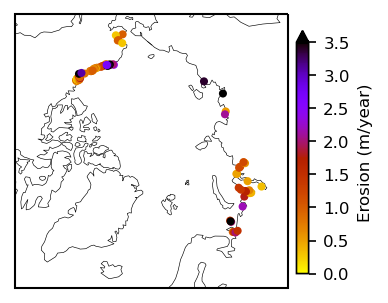

In [5]:
fig = plt.figure(figsize=(2.7, 2.7), dpi=150)
proj=ccrs.NorthPolarStereo()

s=15
fontsize=8
vmax=3.5
vmin=0
res='110m'

ax = fig.add_subplot(111,projection=proj)
ax.set_extent([-180, 180, 63, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution=res, lw=0.3, edgecolor='grey')
m=ax.scatter(cxx_train,cyy_train, c=mydf_train['Eros'].values, s=s, vmin=vmin, vmax=vmax, 
             cmap='gnuplot_r', transform=ccrs.PlateCarree(),zorder=2, edgecolor='none')
m=ax.scatter(cxx_ex_train,cyy_ex_train, c=mydf_ex_train['Eros'].values, s=s, vmin=vmin, vmax=vmax, 
             cmap='gnuplot_r', transform=ccrs.PlateCarree(),zorder=2, edgecolor='none')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.2, 0.03, 0.6])
cbar = fig.colorbar(m, cax=cbar_ax, extend='max')
cbar.set_clim(vmin, vmax)
cbar.set_label(label='Erosion (m/year)',fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()


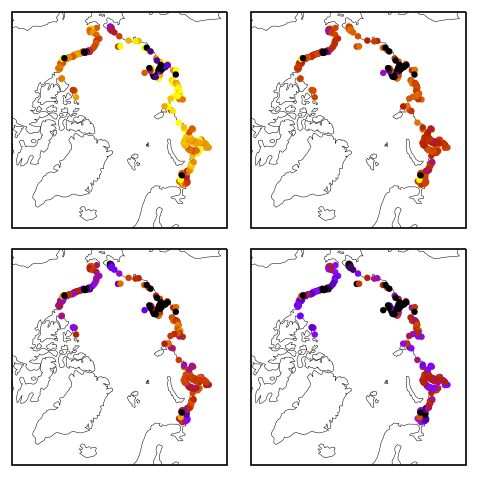

In [6]:
fig = plt.figure(figsize=(4.9, 5), dpi=120)
proj=ccrs.NorthPolarStereo()

s=15
fontsize=8
vmax=3.5
vmin=0
res='110m'


ax = fig.add_subplot(221,projection=proj)
ax.set_extent([-180, 180, 63, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution=res, lw=0.3, edgecolor='grey')
m=ax.scatter(cxx_force_all,cyy_force_all, c=eros_hist, s=s, vmin=vmin, vmax=vmax, 
             cmap='gnuplot_r', transform=ccrs.PlateCarree(),zorder=2, edgecolor='none')

ax = fig.add_subplot(222,projection=proj)
ax.set_extent([-180, 180, 63, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution=res, lw=0.3, edgecolor='grey')
m=ax.scatter(cxx_force_all,cyy_force_all, c=eros_s126, s=s, vmin=vmin, vmax=vmax, 
             cmap='gnuplot_r', transform=ccrs.PlateCarree(),zorder=2, edgecolor='none')

ax = fig.add_subplot(223,projection=proj)
ax.set_extent([-180, 180, 63, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution=res, lw=0.3, edgecolor='grey')
m=ax.scatter(cxx_force_all,cyy_force_all, c=eros_s245, s=s, vmin=vmin, vmax=vmax, 
             cmap='gnuplot_r', transform=ccrs.PlateCarree(),zorder=2, edgecolor='none')

ax = fig.add_subplot(224,projection=proj)
ax.set_extent([-180, 180, 63, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution=res, lw=0.3, edgecolor='grey')
m=ax.scatter(cxx_force_all,cyy_force_all, c=eros_s585, s=s, vmin=vmin, vmax=vmax, 
             cmap='gnuplot_r', transform=ccrs.PlateCarree(),zorder=2, edgecolor='none')

plt.subplots_adjust(wspace=0.10, hspace=0.10)
plt.show()


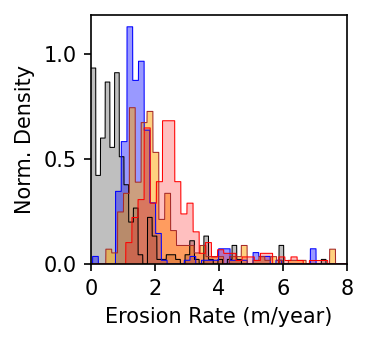

In [7]:
x = np.linspace(0, 10, int(10*1000))

fig = plt.figure(figsize=(2.2, 2.2), dpi=150)
ax = fig.add_subplot(111)

plt.hist(eros_hist, bins=50, alpha=0.5, color='grey', density=True)
h = np.histogram(eros_hist, bins=50)
hist_dist = stats.rv_histogram(h)
plt.plot(x, hist_dist.pdf(x), 'k', lw=0.5)

plt.hist(eros_s126, bins=50, alpha=0.4, color='b', density=True)
h = np.histogram(eros_s126, bins=50)
s126_dist = stats.rv_histogram(h)
plt.plot(x, s126_dist.pdf(x), 'b', lw=0.5)

plt.hist(eros_s245, bins=50, alpha=0.5, color='orange', density=True)
h = np.histogram(eros_s245, bins=50)
s245_dist = stats.rv_histogram(h)
plt.plot(x, s245_dist.pdf(x), 'brown', lw=0.5)

plt.hist(eros_s585, bins=50, alpha=0.25, color='r', density=True)
h = np.histogram(eros_s585, bins=50)
s585_dist = stats.rv_histogram(h)
plt.plot(x, s585_dist.pdf(x), 'r', lw=0.5)

plt.xlim((0,8.0))
plt.yticks(np.arange(0,1.5,0.5),np.arange(0,1.5,0.5))
plt.xlabel('Erosion Rate (m/year)')
plt.ylabel('Norm. Density')
plt.show()


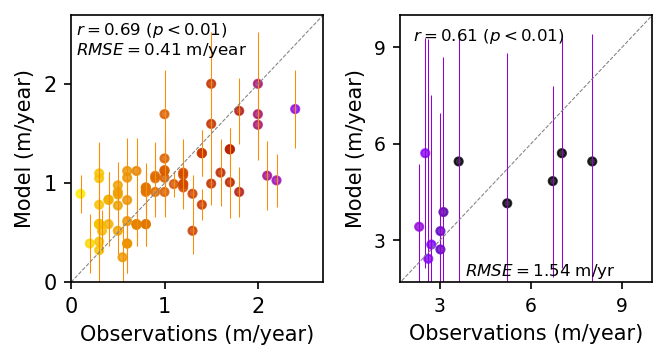

In [8]:
def rmse(x,y):
    '''
    Root Mean Square Error
    '''
    import numpy as np
    return np.sqrt(np.nansum((x-y)**2)/len(x))

viridis = cm.get_cmap('gnuplot_r', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([125/256, 256/256, 256/256, 0])
newcolors[:1, :] = pink
cmap = ListedColormap(newcolors)

fig = plt.figure(figsize=(4.55,2.5), dpi=150)
ax = fig.add_subplot(121)

plt.errorbar(eros_obs, eros_ERA20C, yerr=eros_ERA20C_2stdUnc, xerr=None, ls='', ecolor='darkorange', elinewidth=0.5)
plt.scatter(eros_obs, eros_ERA20C, alpha=0.8, cmap=cmap, c=eros_obs, vmin=vmin, vmax=vmax, s=15)
r = np.corrcoef(eros_obs, eros_ERA20C)[0,1]
rms = rmse(eros_obs, eros_ERA20C)
plt.yticks([0,1,2,3],[0,1,2,3])
plt.xticks([0,1,2,3],[0,1,2,3])
plt.plot(np.arange(-3,4), np.arange(-3,4), ls='--', lw=0.5, c='grey')
plt.xlabel('Observations (m/year)'); plt.ylabel('Model (m/year)')
plt.xlim((0, 2.7)); plt.ylim((0, 2.7))
plt.text(0.05,2.5,'$r=%.2f$ ($p<0.01$)'%r, fontsize=8)
plt.text(0.05,2.3,'$RMSE=%.2f$ m/year'%(rms), fontsize=8)

ax = fig.add_subplot(122)

plt.errorbar(eros_obs_ext, eros_ERA20C_ext, yerr=eros_ERA20C_2stdUnc_ext, xerr=None, ls='', ecolor='darkviolet', elinewidth=0.5)
plt.scatter(eros_obs_ext, eros_ERA20C_ext, alpha=0.8, cmap=cmap, c=eros_obs_ext, vmin=vmin, vmax=vmax, s=15)
r = np.corrcoef(eros_obs_ext, eros_ERA20C_ext)[0,1]
rms = rmse(eros_obs_ext, eros_ERA20C_ext)
plt.yticks([3,6,9],[3,6,9], fontsize=9)
plt.xticks([3,6,9],[3,6,9], fontsize=9)
plt.plot(np.arange(-3,14), np.arange(-3,14), ls='--', lw=0.5, c='grey')
plt.xlabel('Observations (m/year)'); plt.ylabel('Model (m/year)')
plt.xlim((1.7, 10)); plt.ylim((1.7,10))
plt.text(2.1,9.2,'$r=%.2f$ ($p<0.01$)'%r, fontsize=8)
plt.text(3.84,1.9,'$RMSE=%.2f$ m/yr'%(rms), fontsize=8)

plt.tight_layout()
plt.show()